In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Import data

In [2]:
infile = '../test7/histos_tbf.0.npz'
loaded = np.load(infile)
out_part = loaded['out_part']
out_hits = loaded['out_hits']

print(out_part.shape, out_hits.shape)

((1968903, 6), (1968903, 50, 2))


### Find mean deflection angles

In [3]:
# Find 'quadstrip' unit
#PATTERN_X_SIZE = 48-1
#PATTERN_X_CENTRAL = 24-1
#PATTERN_X_DIV = 32

# Find 'fullstrip' unit
PATTERN_X_SIZE = 192-1
PATTERN_X_CENTRAL = 96-1
PATTERN_X_DIV = 8

PATTERN_X_SECTOR = 5400/PATTERN_X_DIV

nlayers = 16

nzones = 7

valid_layers = np.zeros((nzones,nlayers), dtype=np.bool)
valid_layers[0, [0,2,3,4,7,8,10,11]]    = True
valid_layers[1, [0,2,3,4,7,8,9,10,11]]  = True
valid_layers[2, [0,2,3,4,7,8,9,10]]     = True
valid_layers[3, [0,2,3,4,7,8,9,10]]     = True
valid_layers[4, [0,1,2,3,4,7,8,9,10]]   = True
valid_layers[5, [1,2,3,4,5,6,7,8]]      = True
valid_layers[6, [1,2,3,5,6,7,12,13,14]] = True

from six.moves import range, zip, map, filter

def _find_bin_fast(x, bins):
  x = np.clip(x, bins[1], bins[2]-1e-7)
  binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
  return binx.astype(np.int32)

def find_eta_bin_16(eta, bins=(16,0.8,2.4)):
  return _find_bin_fast(np.abs(eta), bins)

def find_pt_bin_100(pt, bins=(100,-0.5,0.5)):
  return _find_bin_fast(pt, bins)

_get_emtf_layer = lambda x: x[0]

_get_emtf_phi = lambda x: x[1]

In [4]:
patterns_match_me2 = np.zeros((100, 16, nlayers, PATTERN_X_SIZE), dtype=np.int32)
patterns_match_me3 = np.zeros((100, 16, nlayers, PATTERN_X_SIZE), dtype=np.int32)

def analysis(verbose=1):

  def _find_dphi():
    dphi = np.float32(0)
    dphi += (hit_phi1 - hit_phi2)
    #dphi /= (np.sinh(1.8587) / np.sinh(np.abs(part_eta)))
    dphi /= PATTERN_X_DIV
    dphi = np.round(dphi)
    return dphi.astype(np.int32)

  # Loop over part and hits
  # - part is (part_invpt, part_eta, part_phi, zone, endsec, mode)
  # - hits is a fixed-size collection of (emtf_layer, emtf_phi) with size=50. 
  #   Invalid hits have emtf_layer=99

  ievt = 0

  for part, hits in zip(out_part, out_hits):
    if verbose and (ievt % 100000 == 0):  print("Processing event: {0}".format(ievt))

    (part_invpt, part_eta, part_phi, zone, endsec, mode) = part
    zone, endsec = int(round(zone)), int(round(endsec))
    hits = hits[hits[:,0] != -99]

    ipt100 = find_pt_bin_100(part_invpt)
    ieta16 = find_eta_bin_16(part_eta)

    amap = {}  # emtf_layer -> hits

    for ihit, hit in enumerate(hits):
      amap.setdefault(_get_emtf_layer(hit), []).append(hit)

    for k, v in amap.iteritems():
      n = len(v)
      amap[k] = v[np.random.randint(n)]  # pick a random hit for each emtf_layer

    # Make pair of hits
    for k, v in amap.iteritems():
      emtf_layer = k
      hit1 = v
      hit_phi1 = _get_emtf_phi(hit1)

      # w.r.t ME2
      emtf_layer_me2 = 2
      hit2 = amap.get(emtf_layer_me2, None)
      if hit2 is not None:
        hit_phi2 = _get_emtf_phi(hit2)
        dphi = _find_dphi()
        dphi = np.clip(dphi, -PATTERN_X_CENTRAL, PATTERN_X_CENTRAL)
        ind = (ipt100, ieta16, emtf_layer, dphi+PATTERN_X_CENTRAL)
        patterns_match_me2[ind] += 1

        # Debug
        if ievt < 10:
          print ievt, part_invpt, part_eta, emtf_layer, hit_phi1, hit_phi2, dphi

      # w.r.t ME3
      emtf_layer_me3 = 3
      hit2 = amap.get(emtf_layer_me3, None)
      if hit2 is not None:
        hit_phi2 = _get_emtf_phi(hit2)
        dphi = _find_dphi()
        dphi = np.clip(dphi, -PATTERN_X_CENTRAL, PATTERN_X_CENTRAL)
        ind = (ipt100, ieta16, emtf_layer, dphi+PATTERN_X_CENTRAL)
        patterns_match_me3[ind] += 1

    ievt += 1
    # end loop over part and hits

  if verbose: print "DONE"
  return

In [5]:
%%time

# Run analysis
analysis()

Processing event: 0
0 -0.21324717 2.4442484 8 3794 3756 5
0 -0.21324717 2.4442484 10 3739 3756 -2
0 -0.21324717 2.4442484 11 3605 3756 -19
0 -0.21324717 2.4442484 2 3756 3756 0
0 -0.21324717 2.4442484 7 3781 3756 3
1 0.11274324 1.8399689 0 3901 3810 11
1 0.11274324 1.8399689 2 3810 3810 0
1 0.11274324 1.8399689 3 3806 3810 0
1 0.11274324 1.8399689 4 3808 3810 0
1 0.11274324 1.8399689 7 3810 3810 0
1 0.11274324 1.8399689 9 3920 3810 14
1 0.11274324 1.8399689 10 3821 3810 1
2 0.10560388 2.1136281 2 3776 3776 0
2 0.10560388 2.1136281 3 3768 3776 -1
2 0.10560388 2.1136281 4 3770 3776 -1
2 0.10560388 2.1136281 7 3769 3776 -1
2 0.10560388 2.1136281 8 3770 3776 -1
2 0.10560388 2.1136281 9 3866 3776 11
2 0.10560388 2.1136281 10 3784 3776 1
2 0.10560388 2.1136281 11 3879 3776 13
3 0.14638212 2.314287 0 2703 2624 10
3 0.14638212 2.314287 2 2624 2624 0
3 0.14638212 2.314287 3 2616 2624 -1
3 0.14638212 2.314287 4 2621 2624 0
3 0.14638212 2.314287 7 2620 2624 0
3 0.14638212 2.314287 8 2623 2624 0
3

In [6]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# https://matplotlib.org/users/dflt_style_changes.html#colors-in-default-property-cycle
# https://github.com/vega/vega/wiki/Scales#scale-range-literals
category10_palette  = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf')
category20_palette  = ('#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5')
category10a_palette = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5')

In [7]:
# Make probability
patterns_match_me2_1 = patterns_match_me2.astype(np.float32)
patterns_match_me3_1 = patterns_match_me3.astype(np.float32)

# Fix issues due to gap between ME2 ring 1 & ring 2 at eta=1.6 (ieta16 between 7&8)
patterns_match_me2_1[:,7,:,:] += patterns_match_me2[:,8,:,:]
patterns_match_me2_1[:,8,:,:] += patterns_match_me2[:,7,:,:]

# Fix issues due to gap between ME3 ring 1 & ring 2 at eta=1.7 (ieta16 between 8&9)
patterns_match_me3_1[:,8,:,:] += patterns_match_me3[:,9,:,:]
patterns_match_me3_1[:,9,:,:] += patterns_match_me3[:,8,:,:]

# Normalize
patterns_match_me2_1_sum = patterns_match_me2_1.sum(axis=-1, keepdims=True)
patterns_match_me3_1_sum = patterns_match_me3_1.sum(axis=-1, keepdims=True)
patterns_match_me2_1[(patterns_match_me2_1_sum < 100)[...,0]] = 0
patterns_match_me3_1[(patterns_match_me3_1_sum < 100)[...,0]] = 0
patterns_match_me2_1_sum[patterns_match_me2_1_sum == 0] = 1
patterns_match_me3_1_sum[patterns_match_me3_1_sum == 0] = 1
patterns_match_me2_1 /= patterns_match_me2_1_sum
patterns_match_me3_1 /= patterns_match_me3_1_sum

In [8]:
# Add up the probabilities, and reverse dphi
patterns_match_me2_2 = 0.5 * (patterns_match_me2_1 + patterns_match_me3_1)[::-1]

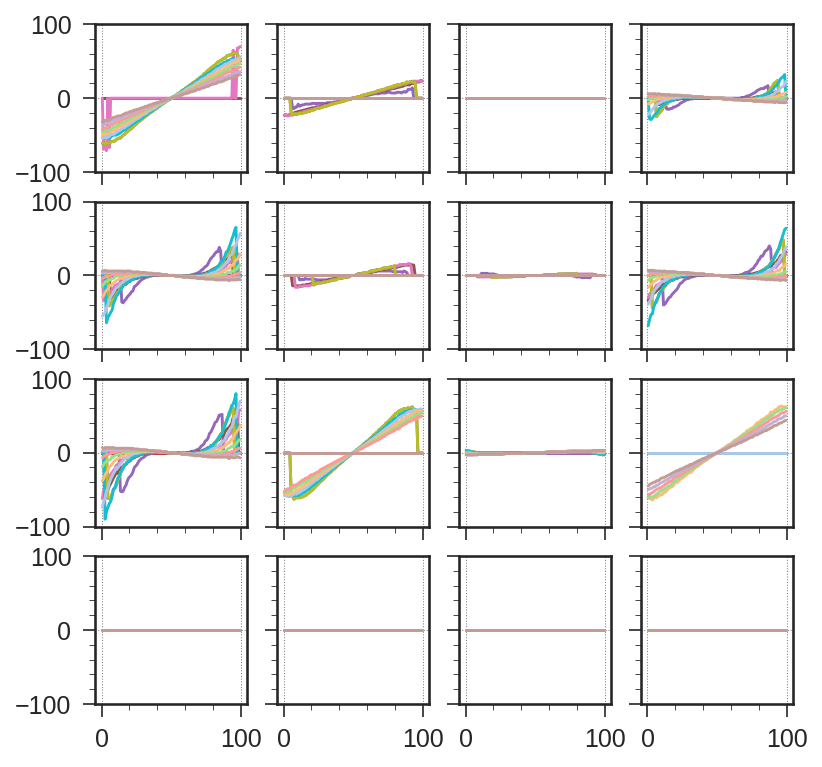

In [9]:
# w.r.t ME2
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(6,6), sharex=True, sharey=True)

for i in xrange(nlayers):
  for j in xrange(16):  # ieta16
    yy = np.zeros(100, dtype=np.float32)
    for k in xrange(100):  # ipt100
      if patterns_match_me2_1[k,j,i].sum() == 0:
        yy[k] = PATTERN_X_CENTRAL
      else:
        yy[k] = np.searchsorted(patterns_match_me2_1[k,j,i].cumsum(), 0.5)  # median
    ax = axs[i/4,i%4]
    ax.plot(np.arange(len(yy))+0.5, yy-PATTERN_X_CENTRAL, color=category10a_palette[j])
    ax.set_ylim(-100,100)

plt.show()

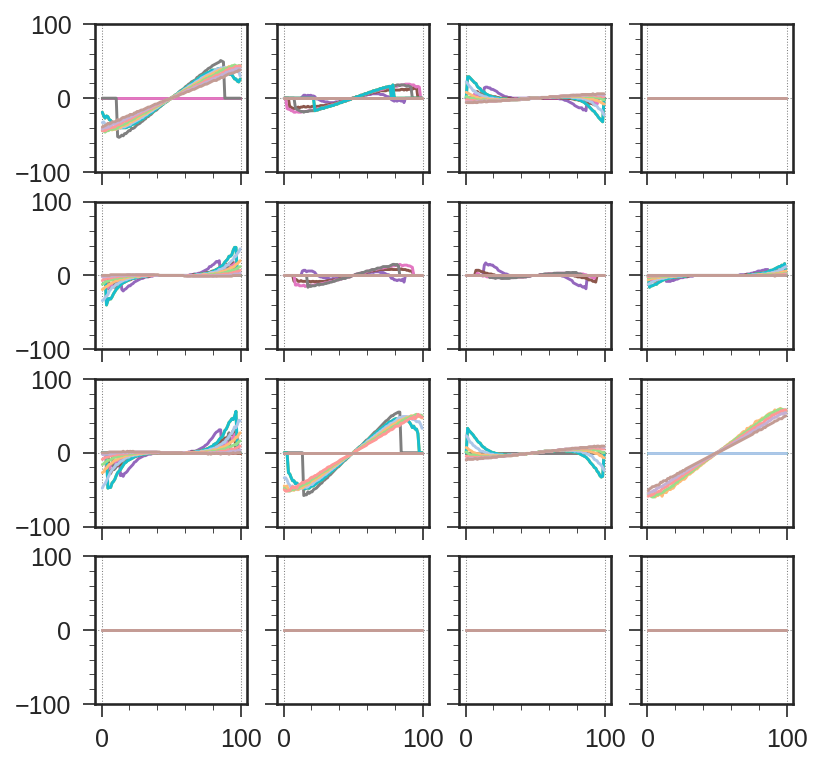

In [10]:
# w.r.t ME3
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(6,6), sharex=True, sharey=True)

for i in xrange(nlayers):
  for j in xrange(16):  # ieta16
    yy = np.zeros(100, dtype=np.float32)
    for k in xrange(100):  # ipt100
      if patterns_match_me3_1[k,j,i].sum() == 0:
        yy[k] = PATTERN_X_CENTRAL
      else:
        yy[k] = np.searchsorted(patterns_match_me3_1[k,j,i].cumsum(), 0.5)  # median
    ax = axs[i/4,i%4]
    ax.plot(np.arange(len(yy))+0.5, yy-PATTERN_X_CENTRAL, color=category10a_palette[j])
    ax.set_ylim(-100,100)

plt.show()

### Find pattern windows

In [11]:
images = np.empty(nzones, dtype=np.object)
for ind in np.ndindex(images.shape):
  images[ind] = []

def analysis2(verbose=1):

  def _find_dphi():
    dphi = np.float32(0)
    dphi += (hit_phi1 - hit_phi2)
    #dphi /= (np.sinh(1.8587) / np.sinh(np.abs(part_eta)))
    dphi /= PATTERN_X_DIV
    dphi = np.round(dphi)
    return dphi.astype(np.int32)

  # Loop over part and hits
  # - part is (part_invpt, part_eta, part_phi, zone, endsec, mode)
  # - hits is a fixed-size collection of (emtf_layer, emtf_phi) with size=50. 
  #   Invalid hits have emtf_layer=99

  ievt = 0

  for part, hits in zip(out_part, out_hits):
    if verbose and (ievt % 100000 == 0):  print("Processing event: {0}".format(ievt))

    (part_invpt, part_eta, part_phi, zone, endsec, mode) = part
    zone, endsec = int(round(zone)), int(round(endsec))
    hits = hits[hits[:,0] != -99]

    ipt100 = find_pt_bin_100(part_invpt)
    ieta16 = find_eta_bin_16(part_eta)

    # Part I - find keystrip
    yy = np.zeros(PATTERN_X_SECTOR, dtype=np.float32)

    for ihit, hit in enumerate(hits):
      emtf_layer = _get_emtf_layer(hit)
      hit_phi1 = _get_emtf_phi(hit)
      hit_phi2 = 0
      dphi = _find_dphi()

      likelihood = patterns_match_me2_2[ipt100, ieta16, emtf_layer]

      ind1 = dphi-PATTERN_X_CENTRAL
      ind2 = dphi+PATTERN_X_CENTRAL+1
      if (dphi-PATTERN_X_CENTRAL) < 0:
        ind1 = -(dphi-PATTERN_X_CENTRAL)
        yy[:ind2] = likelihood[ind1:]
      elif (dphi+PATTERN_X_CENTRAL+1) > PATTERN_X_SECTOR:
        ind2 = -(dphi+PATTERN_X_CENTRAL+1) + PATTERN_X_SECTOR
        yy[ind1:] += likelihood[:ind2]
      else:
        yy[ind1:ind2] += likelihood

      # Debug
      if ievt < 10:
        print ievt, part_invpt, part_eta, emtf_layer, hit_phi1, hit_phi2, dphi, np.argmax(likelihood)-PATTERN_X_CENTRAL

    # Part II - make image
    image = np.zeros((nlayers, PATTERN_X_SIZE), dtype=np.bool)

    keystrip = np.argmax(yy)  # max likelihood

    for ihit, hit in enumerate(hits):
      emtf_layer = _get_emtf_layer(hit)
      hit_phi1 = _get_emtf_phi(hit)
      hit_phi2 = 0
      dphi = _find_dphi()

      row = emtf_layer
      col = (dphi - keystrip)
      if -PATTERN_X_CENTRAL <= col <= PATTERN_X_CENTRAL:
        image[row, col+PATTERN_X_CENTRAL] = 1

      # Debug
      if ievt < 10:
        print '..', part_invpt, part_eta, emtf_layer, hit_phi1, hit_phi2, dphi, keystrip, col

    images[zone].append(image)
    ievt += 1
    # end loop over part and hits

  if verbose: print "DONE"
  return

In [12]:
%%time

# Run analysis
analysis2()

Processing event: 0
0 -0.21324717 2.4442484 10 3736 0 467 2
0 -0.21324717 2.4442484 10 3739 0 467 2
0 -0.21324717 2.4442484 11 3605 0 451 18
0 -0.21324717 2.4442484 2 3756 0 470 0
0 -0.21324717 2.4442484 7 3781 0 473 0
0 -0.21324717 2.4442484 8 3794 0 474 -2
.. -0.21324717 2.4442484 10 3736 0 467 470 -3
.. -0.21324717 2.4442484 10 3739 0 467 470 -3
.. -0.21324717 2.4442484 11 3605 0 451 470 -19
.. -0.21324717 2.4442484 2 3756 0 470 470 0
.. -0.21324717 2.4442484 7 3781 0 473 470 3
.. -0.21324717 2.4442484 8 3794 0 474 470 4
1 0.11274324 1.8399689 9 3920 0 490 -16
1 0.11274324 1.8399689 10 3821 0 478 -1
1 0.11274324 1.8399689 0 3901 0 488 -12
1 0.11274324 1.8399689 2 3810 0 476 0
1 0.11274324 1.8399689 3 3806 0 476 0
1 0.11274324 1.8399689 7 3810 0 476 0
1 0.11274324 1.8399689 4 3808 0 476 0
.. 0.11274324 1.8399689 9 3920 0 490 476 14
.. 0.11274324 1.8399689 10 3821 0 478 476 2
.. 0.11274324 1.8399689 0 3901 0 488 476 12
.. 0.11274324 1.8399689 2 3810 0 476 476 0
.. 0.11274324 1.8399689

In [13]:
outfile = 'keras_logs/myimages_out.npz'
np.savez_compressed(outfile,
                    images_zone0=np.asarray(images[0]),
                    images_zone1=np.asarray(images[1]),
                    images_zone2=np.asarray(images[2]),
                    images_zone3=np.asarray(images[3]),
                    images_zone4=np.asarray(images[4]),
                    images_zone5=np.asarray(images[5]),
                    images_zone6=np.asarray(images[6]),
                   )

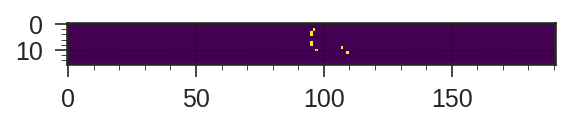

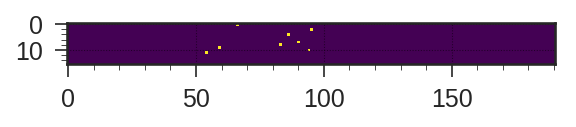

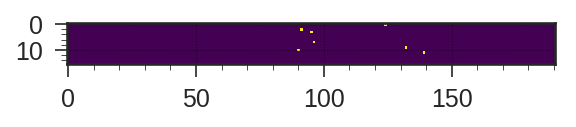

In [14]:
plt.imshow(images[1][0])
plt.show()
plt.imshow(images[1][1])
plt.show()
plt.imshow(images[1][2])
plt.show()